# Housing Price Simulation.

A notebook by *List your names here*.

Then, add alternating code cells and description/markdown cells,
between this top cell and the final "Running DocTest tests" section,
to answer all the elements of the final project programming assignment.

The answer to each part must be clearly identified with,
the text "Step 1" for Step 1, "Step 2" for Step 2, etc.
As noted in the assignment, you may do some of the work in copies of this project
for different sub-experiments,
rather than just putting it all in this notebook,
if you like.

In [154]:
import numpy as np
import doctest
import matplotlib.pyplot as plt
import pandas as pd
import math

seed=4221724

## Data Generation

In [155]:
def gen_data(n, y_min, alpha, mu, c, seed=1):
    
  # Validate parameters
    if y_min <= c:
        raise ValueError("y_min needs to be greater than c")
    if alpha <= 1:
        raise ValueError("alpha neds to be greater than 1")
    if mu <= 0:
        raise ValueError("mu needs to be positive")

    U = np.random.uniform(size=n)
    y = y_min * (1 - U) ** (-1.0 / alpha)

    U_exp = np.random.uniform(size=n)
    d = -mu * np.log(U_exp)

    y = np.sort(y)[::-1]
    d = np.sort(d)

   
    return y, d

## Data Gen Validation

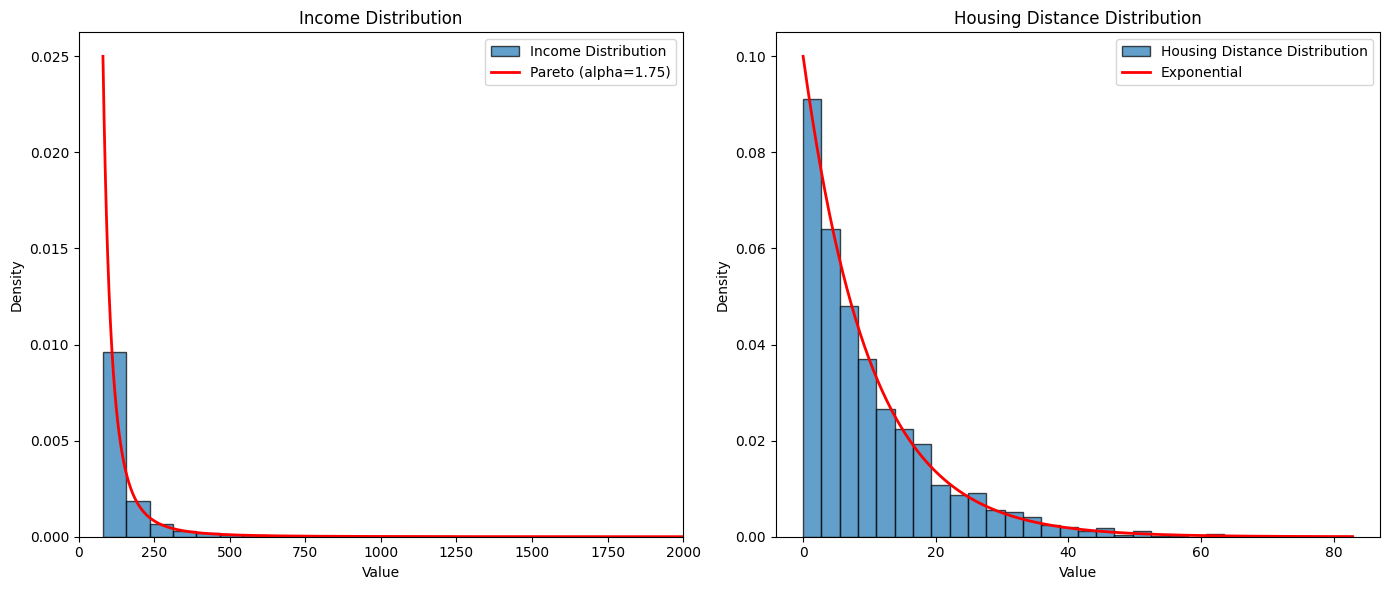

Income: [7818.54200857 2780.23734669 2652.47390213 ...   80.02844698   80.01392405
   80.00263155]
Housing Distance: [1.95893068e-03 2.33834216e-03 9.49663260e-03 ... 6.50476646e+01
 6.82577006e+01 8.28172421e+01]


In [156]:

# PLOT DISTRIBUTIONS 

def plot_distributions(n,y_min,alpha,mu,c,seed,xlim):
    
    y,d,=gen_data(n, y_min, alpha, mu, c, seed)

    # check to see if they look pareto and exp
    
    plt.figure(figsize=(14, 6))  

    # Income Distribution
    plt.subplot(1, 2, 1)
    plt.hist(y, bins=100, density=True, alpha=0.7, edgecolor="black", label="Income Distribution")
    plt.title("Income Distribution")
    plt.xlabel("Value")
    plt.ylabel("Density")
    plt.xlim(0, xlim) 

    # Add Pareto line
    pareto_x = np.linspace(y_min, xlim, xlim)
    pareto_pdf = (alpha * y_min**alpha) / (pareto_x ** (alpha + 1))
    plt.plot(pareto_x, pareto_pdf, 'r-', lw=2, label="Pareto (alpha=1.75)")
    plt.legend()

    # Housing Distance Distribution
    plt.subplot(1, 2, 2)
    plt.hist(d, bins=30, density=True, alpha=0.7, edgecolor="black", label="Housing Distance Distribution")
    plt.title("Housing Distance Distribution")
    plt.xlabel("Value")
    plt.ylabel("Density")

    # Add Exponential line
    exp_x = np.linspace(0, d.max(), 500)
    exp_pdf = (1 / mu) * np.exp(-exp_x / mu)
    plt.plot(exp_x, exp_pdf, 'r-', lw=2, label="Exponential")
    plt.legend()

    plt.tight_layout()
    plt.show()
    
    print(f'Income: {y}')
    print(f'Housing Distance: {d}')


# Generate samples for visualization
n_test = 2000
y_min_test = 80
alpha_test = 2
mu_test = 10
c_test = 50


plot_distributions(n_test,y_min_test,alpha_test,mu_test,c_test,seed,xlim=2000) #xlim for readibility



## Visualization and Statistics

In [157]:
def compute_statistics(prices):
    average = np.mean(prices)
    median = np.median(prices)
    Q1 = np.percentile(prices, 25)
    Q3 = np.percentile(prices, 75)
    IQR = Q3 - Q1

    statistics = {
        'average': average,
        'median': median,
        'Q1' : Q1,
        'Q3' : Q3,
        'IQR': IQR
    }

    return statistics


def plot_house_prices(y, prices):
    n = len(y)
    income_quantiles = np.linspace(1, 0, n)

    plt.figure(figsize=(12, 6))
    plt.scatter(income_quantiles, prices, s=10, alpha=0.5, color='b')
    plt.xlabel('Income Quantile (0 = Lowest Income, 1 = Highest Income)')
    plt.ylabel('House Price')
    plt.title('House Prices vs. Income Quantile')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


def plot_percentage_income_spent(y, prices):
    n = len(y)
    income_quantiles = np.linspace(1, 0, n)
    with np.errstate(divide='ignore', invalid='ignore'):
        percentage_spent = np.where(y != 0, (prices / y) * 100, 0)

    plt.figure(figsize=(10, 6))
    plt.plot(income_quantiles, percentage_spent, marker='s', linestyle='--', color='r')
    plt.xlabel('Income Quantile (0 = Lowest Income, 1 = Highest Income)')
    plt.ylabel('Percentage of Income Spent on Housing (%)')
    plt.title('Percentage of Income Spent on Housing vs. Income Quantile')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

#plot_house_prices(y, prices)
#plot_percentage_income_spent(y, prices)
#print(compute_statistics(prices))

## 2a: basic recursion

In [158]:
def get_price_recursive(j, n, c, y, d):
    # Input checks:
    if j < 1 or j > n:
        raise ValueError("invalid j")

    # Base case: p_n = c
    if j == n:
        return c

    # Recursive step:
    theta_j = math.exp(-(d[j] - d[j-1]))  # d[j] = d_j+1
    
    # Using 0-based indexing: y[j] is y_j+1
    p_j_plus_1 = get_price_recursive(j+1, n, c, y, d)
    
    p_j = theta_j * p_j_plus_1 + (1 - theta_j) * y[j]  # y[j] = y_j+1
    return p_j

# create price array
def calc_prices_recursive(n, c, y, d):
    prices = []
    for j in range(1, n+1):
        p_j = get_price_recursive(j, n, c, y, d)
        prices.append(p_j)
    return prices

## 2b: memo

In [159]:
def calc_price_memo(n, c, y, d):
    memo = np.full(n, np.nan) # init n sized array
    memo[0] = c  # Base case: p_n = c

    def calc_equilibrum(j):
        if not np.isnan(memo[j]):
            return memo[j]

        # Calculate theta_j
        theta_j = np.exp(-(d[j] - d[j - 1]))

        # Recursive calculation for the previous price
        previous_price = calc_equilibrum(j - 1)

        # Calculate current equilibrium price
        memo[j] = theta_j * previous_price + (1 - theta_j) * y[j]
        return memo[j]

    # Compute prices for all indices
    for j in range(1, n):
        calc_equilibrum(j)

    memo=np.sort(memo)[::-1]
    return memo

## 2c: Iterative 

In [160]:

def calc_prices_iterative(n, c, y, d):
    if not all(y[i] >= y[i+1] for i in range(n-1)):
        raise ValueError("Incomes y must be sorted in descending order.")
    if not all(d[i] <= d[i+1] for i in range(n-1)):
        raise ValueError("Distances d must be sorted in ascending order.")

    prices = [0] * n
    prices[-1] = c  # p_n = c

    for j in range(n-2, -1, -1):  # from p_{n-1} to p_1
        theta_j = math.exp(-(d[j+1] - d[j]))
        prices[j] = theta_j * prices[j+1] + (1 - theta_j) * y[j+1]
    
    return prices

## 4a

   y_min     average      median          Q1          Q3         IQR
0     80  136.983248  113.031534   93.060375  154.995649   61.935274
1    100  172.947388  141.929934  115.222736  197.414544   82.191809
2    150  261.223671  215.654254  172.427960  290.540881  118.112921


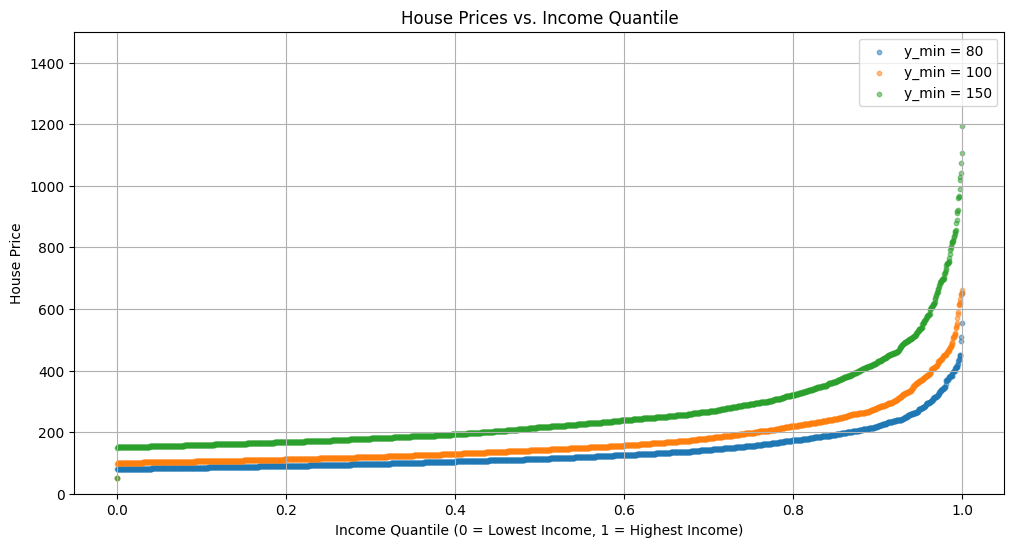

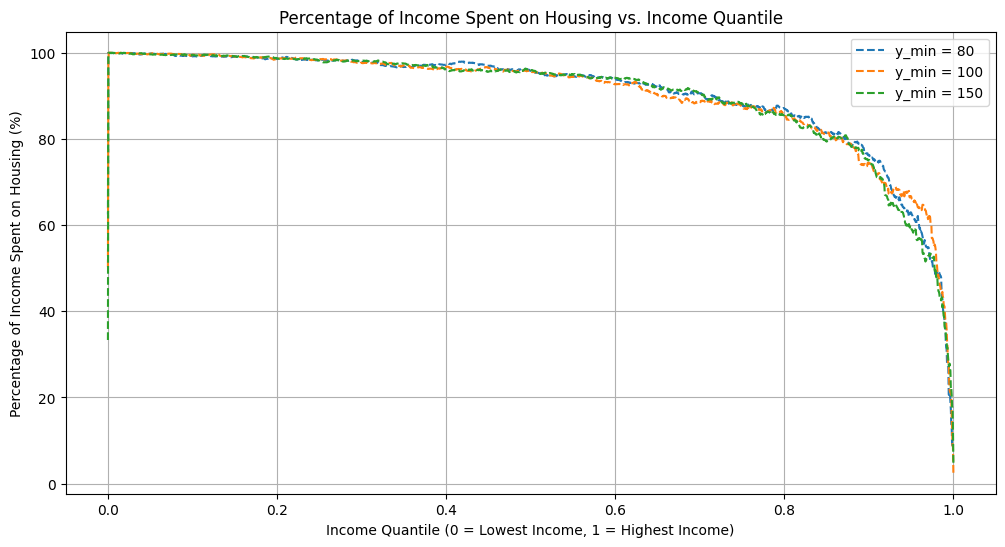

In [161]:
n = 2000
y_min_list = [80, 100, 150]
alpha = 1.75
mu = 10
c = 50

stats_list = []  # Store stats for table
all_y = []        # Store income data
all_prices = []   # Store prices

# Iterate over each y_min value
for y_min in y_min_list:
    y, d = gen_data(n, y_min, alpha, mu, c,seed)
    prices = calc_prices_iterative(n, c, y, d)
   
    # Store the data
    all_y.append(y)
    all_prices.append(prices)
    
    # Compute statistics
    stats = compute_statistics(prices)
    stats['y_min'] = y_min  
    stats_list.append(stats)
    
    # Test base case
   # base_case_price = prices[0]  # This is the price of house j=1
   # if base_case_price == c:
   #     base_case_result = f"Base Case check passed: {base_case_price}"
  #  else:
   #     base_case_result = f"Base Case check failed: {base_case_price}"

stats_df = pd.DataFrame(stats_list)
stats_df = stats_df[['y_min', 'average', 'median', 'Q1', 'Q3', 'IQR']]
print(stats_df)


# Create plots after the loop
income_quantiles = np.linspace(1, 0, n)

# First plot: House Prices vs Income Quantile
plt.figure(figsize=(12, 6))
for i, (prices, y_min) in enumerate(zip(all_prices, y_min_list)):
    plt.scatter(income_quantiles, prices, s=10, alpha=0.5, label=f'y_min = {y_min}')
plt.ylim(0, 1500)
plt.xlabel('Income Quantile (0 = Lowest Income, 1 = Highest Income)')
plt.ylabel('House Price')
plt.title('House Prices vs. Income Quantile')
plt.grid(True)
plt.legend()
plt.show()

# Second plot: Percentage of Income Spent
plt.figure(figsize=(12, 6))
for i, (y, prices, y_min) in enumerate(zip(all_y, all_prices, y_min_list)):
    percentage_spent = np.where(y != 0, (prices / y) * 100, 0)
    plt.plot(income_quantiles, percentage_spent, linestyle='--', label=f'y_min = {y_min}')

plt.xlabel('Income Quantile (0 = Lowest Income, 1 = Highest Income)')
plt.ylabel('Percentage of Income Spent on Housing (%)')
plt.title('Percentage of Income Spent on Housing vs. Income Quantile')
plt.grid(True)
plt.legend()
plt.show()



### 4b

   alpha     average      median         Q1          Q3         IQR
0   1.25  181.969104  128.748565  98.334663  200.268605  101.933942
1   1.75  138.389765  110.948178  91.047543  153.511464   62.463920
2   3.00  107.755563   97.754814  87.265938  120.147709   32.881771


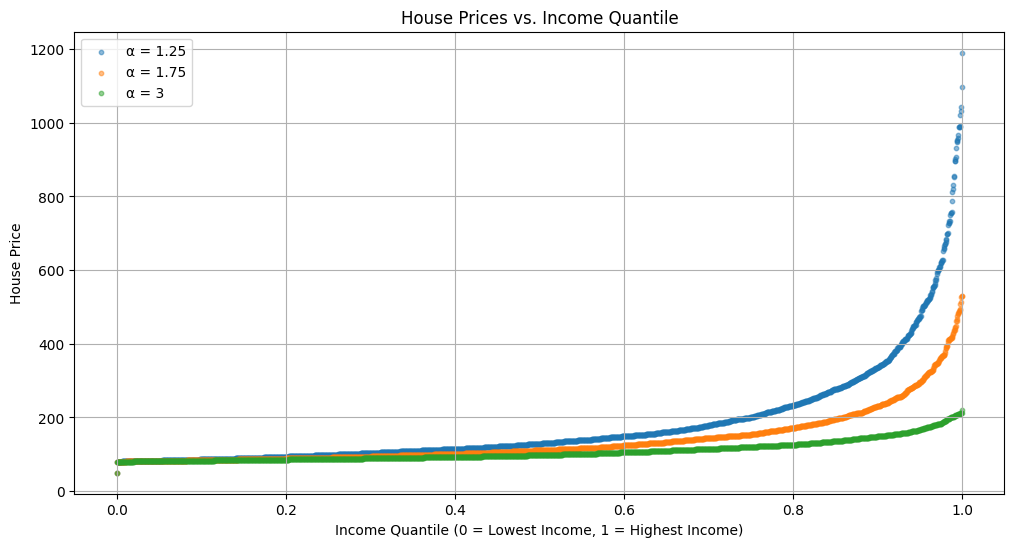

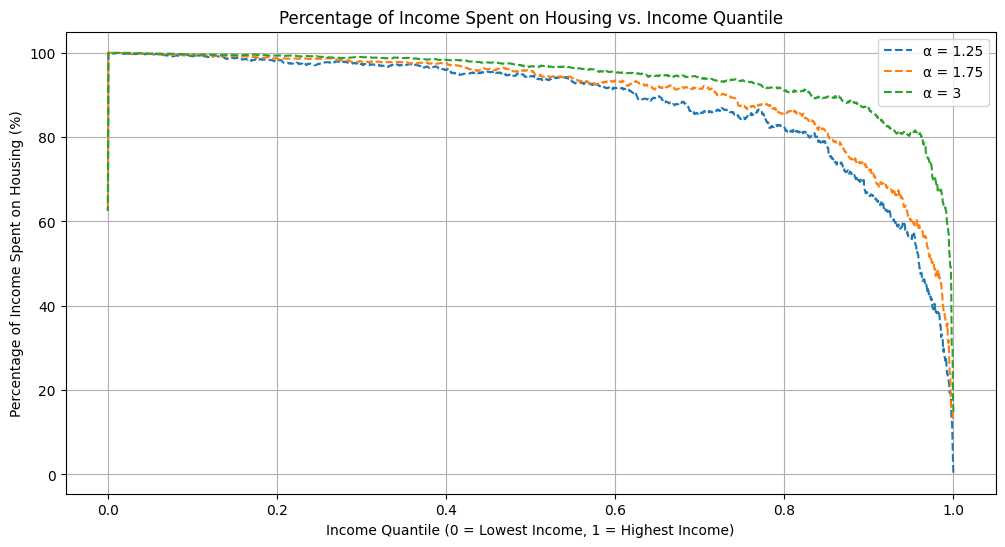

In [162]:
n = 2000
alpha_list = [1.25, 1.75, 3]
y_min = 80
mu = 10
c = 50

stats_list = []  # Store stats for table
all_y = []        # Store income data
all_prices = []   # Store prices

# Iterate over each alpha
for alpha in alpha_list:

    y, d = gen_data(n, y_min, alpha, mu, c,seed)
    prices = calc_prices_iterative(n, c, y, d)
    
    # Store the data
    all_y.append(y)
    all_prices.append(prices)
    
    # Compute statistics
    stats = compute_statistics(prices)
    stats['alpha'] = alpha  
    stats_list.append(stats)

# df for table
stats_df = pd.DataFrame(stats_list)
stats_df = stats_df[['alpha', 'average', 'median', 'Q1', 'Q3', 'IQR']]
print(stats_df)

# Create plots after the loop
income_quantiles = np.linspace(1, 0, n)

# First plot: House Prices vs Income Quantile
plt.figure(figsize=(12, 6))
for i, (prices, alpha) in enumerate(zip(all_prices, alpha_list)):
    plt.scatter(income_quantiles, prices, s=10, alpha=0.5, label=f'α = {alpha}')  

#plt.ylim(0, 1000)
plt.xlabel('Income Quantile (0 = Lowest Income, 1 = Highest Income)')
plt.ylabel('House Price')
plt.title('House Prices vs. Income Quantile')
plt.grid(True)
plt.legend()
plt.show()

# Second plot: Percentage of Income Spent
plt.figure(figsize=(12, 6))
for i, (y, prices, alpha) in enumerate(zip(all_y, all_prices, alpha_list)):
    percentage_spent = np.where(y != 0, (prices / y) * 100, 0)
    plt.plot(income_quantiles, percentage_spent, linestyle='--', label=f'α = {alpha}') 
plt.xlabel('Income Quantile (0 = Lowest Income, 1 = Highest Income)')
plt.ylabel('Percentage of Income Spent on Housing (%)')
plt.title('Percentage of Income Spent on Housing vs. Income Quantile')
plt.grid(True)
plt.legend()
plt.show()

### 4c

   mu     average      median         Q1          Q3        IQR
0   5  129.837910  110.751467  91.739191  146.505147  54.765956
1  10  139.087003  112.932540  92.132961  157.484744  65.351783
2  20  148.436397  116.571937  93.794716  166.271714  72.476997


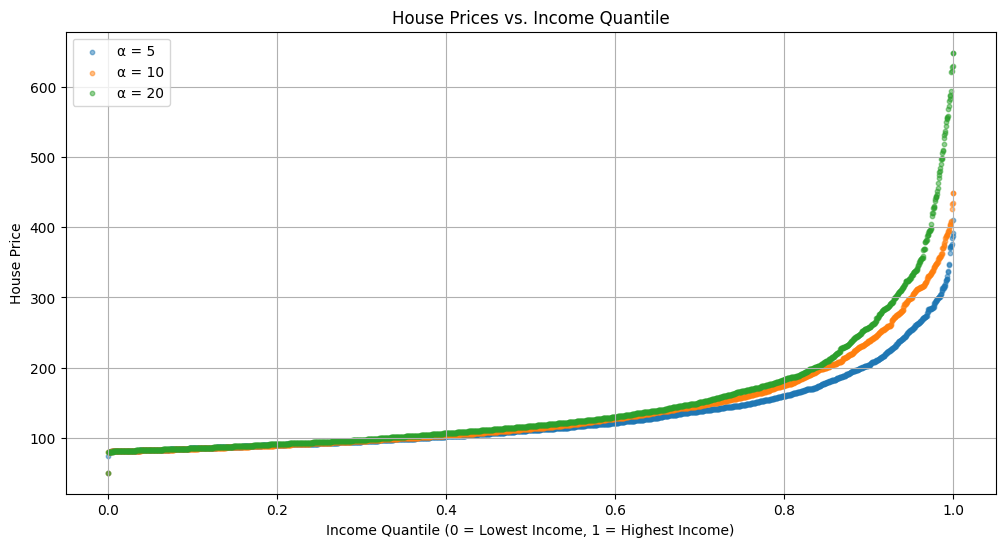

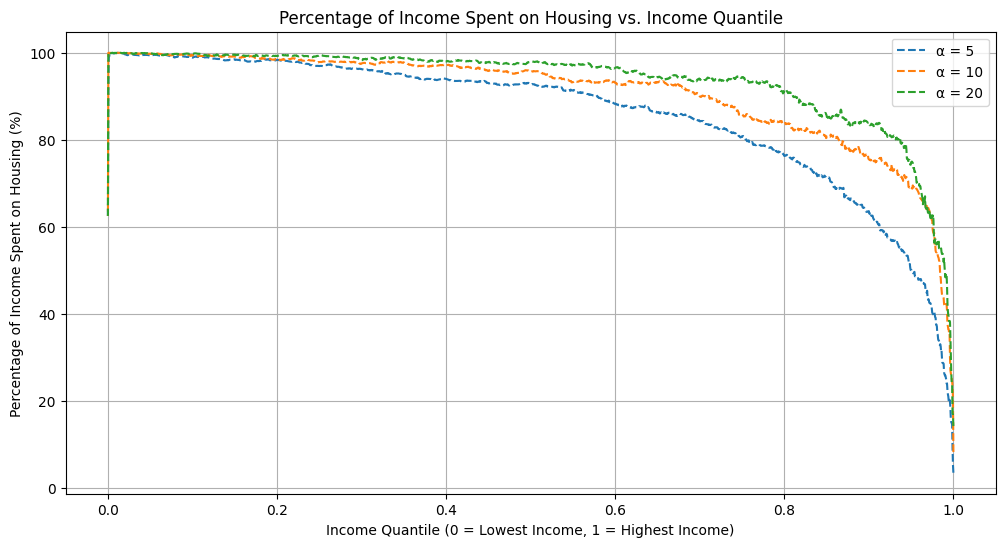

In [163]:
n = 2000
mu_list = [5,10,20]
y_min = 80
alpha = 1.75
c = 50


# Initialize lists to collect statistics and data
stats_list = []
all_y = []  # Store income data
all_prices = []  # Store price data

# Iterate over each alpha
for mu in mu_list:

    y, d = gen_data(n, y_min, alpha, mu, c,seed)
    prices = calc_prices_iterative(n, c, y, d)
    
    # Store the data
    all_y.append(y)
    all_prices.append(prices)
    
    # Compute statistics
    stats = compute_statistics(prices)
    stats['mu'] = mu  
    stats_list.append(stats)

# df for table
stats_df = pd.DataFrame(stats_list)
stats_df = stats_df[['mu', 'average', 'median', 'Q1', 'Q3', 'IQR']]  
print(stats_df)

# Create plots after the loop
income_quantiles = np.linspace(1, 0, n)

# First plot: House Prices vs Income Quantile
plt.figure(figsize=(12, 6))
for i, (prices, mu) in enumerate(zip(all_prices, mu_list)):
    plt.scatter(income_quantiles, prices, s=10, alpha=0.5, label=f'α = {mu}') 
#plt.ylim(0, 1000)
plt.xlabel('Income Quantile (0 = Lowest Income, 1 = Highest Income)')
plt.ylabel('House Price')
plt.title('House Prices vs. Income Quantile')
plt.grid(True)
plt.legend()
plt.show()

# Second plot: Percentage of Income Spent
plt.figure(figsize=(12, 6))
for i, (y, prices, mu) in enumerate(zip(all_y, all_prices, mu_list)):
    percentage_spent = np.where(y != 0, (prices / y) * 100, 0)
    plt.plot(income_quantiles, percentage_spent, linestyle='--', label=f'α = {mu}')  # Fixed: Label shows alpha
plt.xlabel('Income Quantile (0 = Lowest Income, 1 = Highest Income)')
plt.ylabel('Percentage of Income Spent on Housing (%)')
plt.title('Percentage of Income Spent on Housing vs. Income Quantile')
plt.grid(True)
plt.legend()
plt.show()

# Population Growth

## Building up

      n     average      median         Q1          Q3        IQR
0  2000  139.135931  114.751398  93.146180  158.983805  65.837625
1  4000  137.514527  114.722589  92.772566  157.355721  64.583155


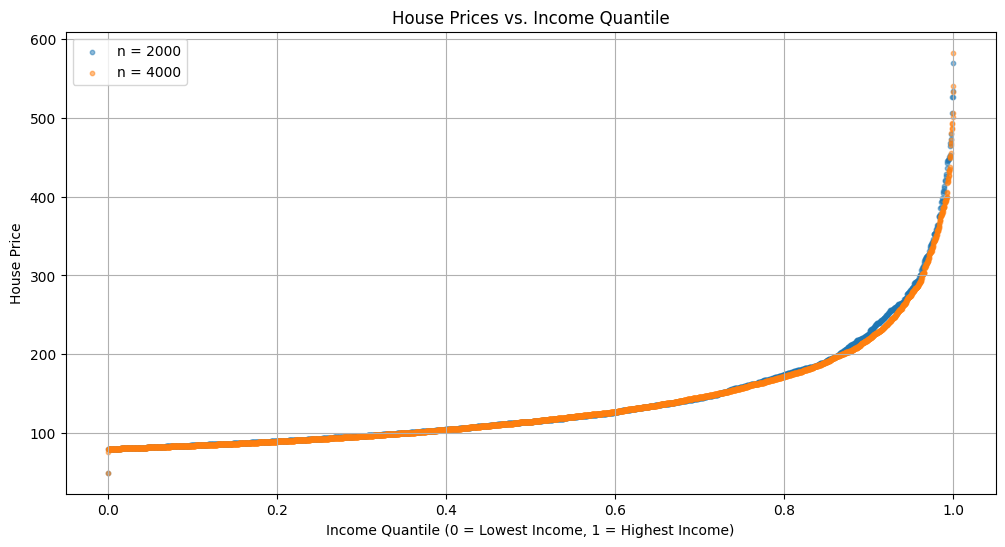

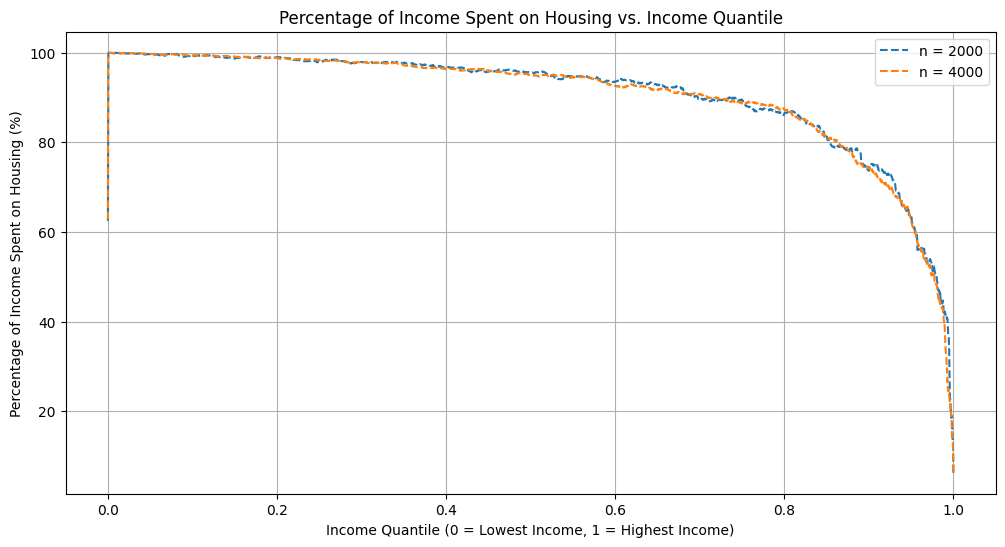

In [164]:
n_list = [2000, 4000]
alpha = 1.75
y_min = 80
mu = 10
c = 50

stats_list = []  # Store stats for table
all_y = []        # Store income data
all_prices = []   # Store prices


for n in n_list:

    y, d = gen_data(n, y_min, alpha, mu, c,seed)
    prices = calc_prices_iterative(n, c, y, d) # the regular recursive approach does not work with n=4000
    all_y.append(y)
    all_prices.append(prices)
    
    # Compute statistics
    stats_i = compute_statistics(prices)
    stats_i['n'] = n  
    stats_list.append(stats_i)

# Create a DataFrame for statistics
stats_df = pd.DataFrame(stats_list)
stats_df = stats_df[['n', 'average', 'median', 'Q1', 'Q3', 'IQR']]
print(stats_df)

# Create plots after the loop

# First Plot: House Prices vs Income Quantile
plt.figure(figsize=(12, 6))
for prices, n in zip(all_prices, n_list):
    income_quantiles = np.linspace(1, 0, len(prices))
    plt.scatter(income_quantiles, prices, s=10, alpha=0.5, label=f'n = {n}')
#plt.ylim(0, 1000)
plt.xlabel('Income Quantile (0 = Lowest Income, 1 = Highest Income)')
plt.ylabel('House Price')
plt.title('House Prices vs. Income Quantile')
plt.grid(True)
plt.legend()
plt.show()

# Second Plot: Percentage of Income Spent
plt.figure(figsize=(12, 6))
for y, prices, n in zip(all_y, all_prices, n_list):
    income_quantiles = np.linspace(1, 0, len(prices))
    percentage_spent = np.where(y != 0, (prices / y) * 100, 0)
    plt.plot(income_quantiles, percentage_spent, linestyle='--', label=f'n = {n}')
plt.xlabel('Income Quantile (0 = Lowest Income, 1 = Highest Income)')
plt.ylabel('Percentage of Income Spent on Housing (%)')
plt.title('Percentage of Income Spent on Housing vs. Income Quantile')
plt.grid(True)
plt.legend()
plt.show()


## Building out

      n  mu     average      median         Q1          Q3        IQR
0  2000  10  137.610874  112.282420  92.506646  155.265012  62.758366
1  4000  20  147.238985  115.900357  93.587371  161.890990  68.303619


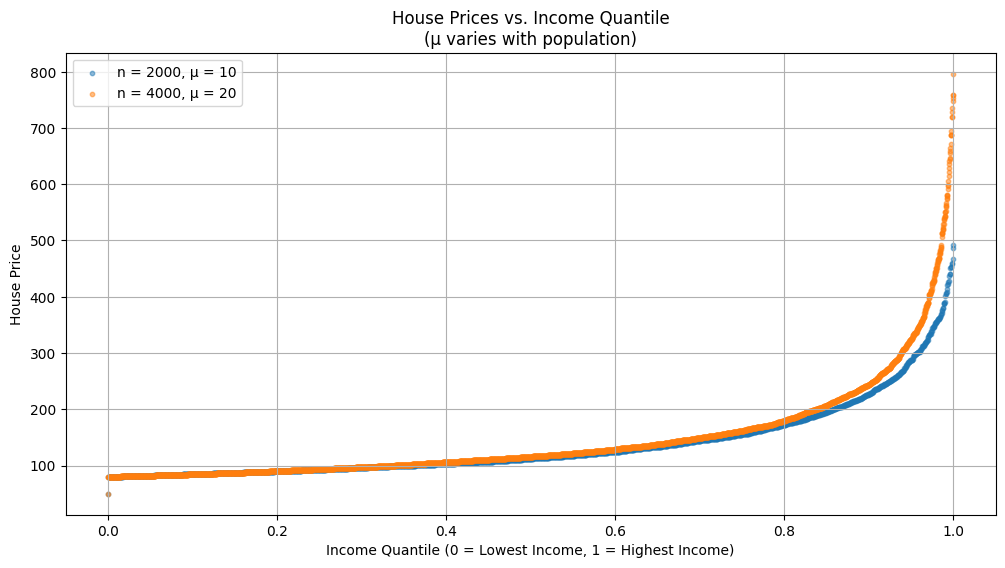

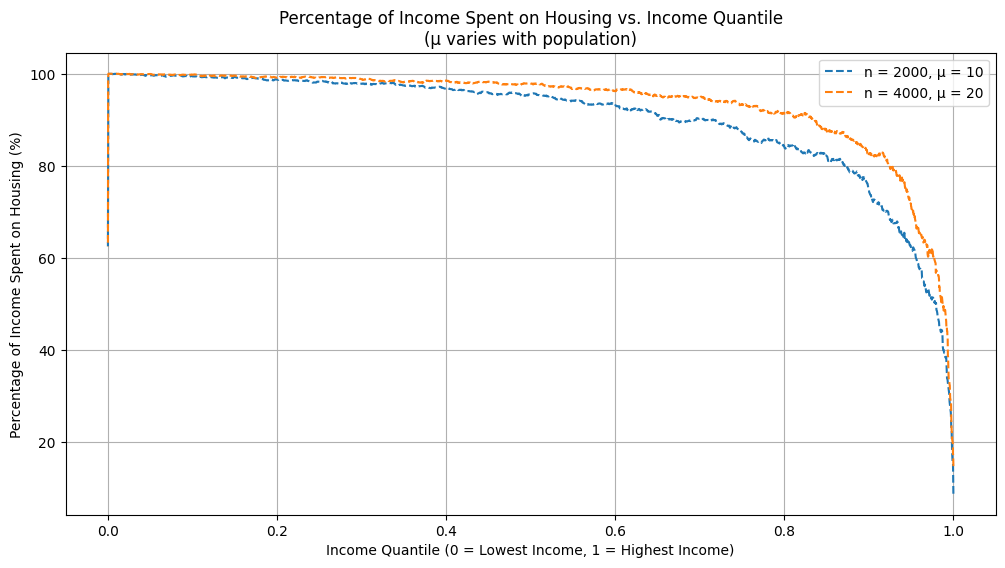

In [165]:
n_list = [2000, 4000]
alpha = 1.75
y_min = 80
c = 50
stats_list = []  # Store stats for table
all_y = []       # Store income data
all_prices = []  # Store prices

# Create dictionary mapping population sizes to mu values
mu_dict = {2000: 10, 4000: 20}  # mu doubles for larger population

for n in n_list:
    # Get appropriate mu for this population size
    mu = mu_dict[n]
    
    y, d = gen_data(n, y_min, alpha, mu, c,seed)
    prices = calc_prices_iterative(n, c, y, d)
    all_y.append(y)
    all_prices.append(prices)
   
    # Compute statistics
    stats_i = compute_statistics(prices)
    stats_i['n'] = n
    stats_i['mu'] = mu  # Add mu to statistics for reference
    stats_list.append(stats_i)

# Create a DataFrame for statistics
stats_df = pd.DataFrame(stats_list)
stats_df = stats_df[['n', 'mu', 'average', 'median', 'Q1', 'Q3', 'IQR']]
print(stats_df)

# First Plot: House Prices vs Income Quantile
plt.figure(figsize=(12, 6))
for prices, n in zip(all_prices, n_list):
    income_quantiles = np.linspace(1, 0, len(prices))
    plt.scatter(income_quantiles, prices, s=10, alpha=0.5, 
                label=f'n = {n}, μ = {mu_dict[n]}')
plt.xlabel('Income Quantile (0 = Lowest Income, 1 = Highest Income)')
plt.ylabel('House Price')
plt.title('House Prices vs. Income Quantile\n(μ varies with population)')
plt.grid(True)
plt.legend()
plt.show()

# Second Plot: Percentage of Income Spent
plt.figure(figsize=(12, 6))
for y, prices, n in zip(all_y, all_prices, n_list):
    income_quantiles = np.linspace(1, 0, len(prices))
    percentage_spent = np.where(y != 0, (prices / y) * 100, 0)
    plt.plot(income_quantiles, percentage_spent, linestyle='--', 
             label=f'n = {n}, μ = {mu_dict[n]}')
plt.xlabel('Income Quantile (0 = Lowest Income, 1 = Highest Income)')
plt.ylabel('Percentage of Income Spent on Housing (%)')
plt.title('Percentage of Income Spent on Housing vs. Income Quantile\n(μ varies with population)')
plt.grid(True)
plt.legend()
plt.show()

## 7

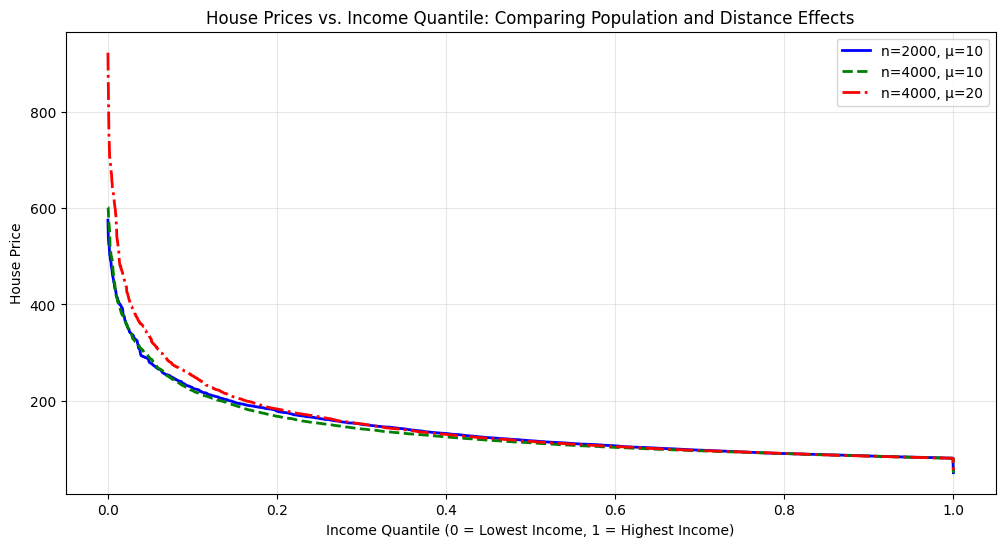

In [166]:
# define dictionary of scenarios because two of the variables change
scenarios = [
    {'n': 2000, 'mu': 10, 'label': 'n=2000, μ=10'},
    {'n': 4000, 'mu': 10, 'label': 'n=4000, μ=10'},
    {'n': 4000, 'mu': 20, 'label': 'n=4000, μ=20'}
]

alpha = 1.75
y_min = 80
c = 50

# Store results
all_prices = []
all_quantiles = []

# Generate data for each scenario
for scenario in scenarios:
    n = scenario['n']
    mu = scenario['mu']
    
    # Generate data and calculate prices
    y, d = gen_data(n, y_min, alpha, mu, c,seed)
    prices = calc_prices_iterative(n, c, y, d)
    
    # Store results
    all_prices.append(prices)
    all_quantiles.append(np.linspace(0, 1, len(prices)))

# plot comparison
plt.figure(figsize=(12, 6))

styles = ['-', '--', '-.']
colors = ['blue', 'green', 'red']

for (prices, quantiles, scenario, style, color) in zip(all_prices, all_quantiles, scenarios, styles, colors):
    plt.plot(quantiles, prices, 
             linestyle=style,
             color=color,
             label=scenario['label'],
             linewidth=2)

plt.xlabel('Income Quantile (0 = Lowest Income, 1 = Highest Income)')
plt.ylabel('House Price')
plt.title('House Prices vs. Income Quantile: Comparing Population and Distance Effects')
plt.grid(True, alpha=0.3)
plt.legend()

#plt.xlim(0.98, 1.01) # zoom in

plt.show()



# Tax

# Check

In [167]:
def check(n, y, d, prices, filename="check.csv"):
 

    # Create a DataFrame with agent information
        data = {
            'Agent': list(range(1, n + 1)),  # Agents numbered from 1 to n
            'Income': y,
            'Distance': d,
            'Price_iterative': prices,
            'Prices_recursive': prices_recursive,
            'Prices_memo': prices_memo
        }
        
        df = pd.DataFrame(data)
        
        # Save to Excel
        df.to_csv(filename, index=False)
        print(f"Data successfully saved to '{filename}'")
        
  
n = 2000
y_min = 80
alpha = 1.75
mu = 10
c = 50

# Generate data
y, d = gen_data(n, y_min, alpha, mu, c, seed)

# Calculate equilibrium prices
prices = calc_prices_iterative(n, c, y, d)
prices_recursive = calc_prices_recursive(n, c, y, d)
prices_memo = calc_price_memo(n, c, y, d)

# Save to csv
check(n, y, d, prices)

Data successfully saved to 'check.csv'


## Data gen

In [168]:
def gen_data_with_tax(n,y_min,alpha,mu,c,tau,seed):

    # Validate parameters
    if y_min <= c:
        raise ValueError("y_min needs to be greater than c")
    if alpha <= 1:
        raise ValueError("alpha needs to be greater than 1")
    if mu <= 0:
        raise ValueError("mu needs to be positive")
    if not 0 <= tau < 1:
        raise ValueError("tau must be between 0 and 1")
        
    np.random.seed(seed)
# gen pretax income    
    U = np.random.uniform(size=n)
    y = y_min * (1 - U) ** (-1.0 / alpha)

# gen distances     
    U_exp = np.random.uniform(size=n)
    d = -mu * np.log(U_exp)
    
    # Sort both arrays
    y = np.sort(y)
    d = np.sort(d)
    
    
    y_bar = np.mean(y)
    
    # Calculate transfer (T = τ * y_bar)
    T = tau * y_bar
    
# Calculate post tax income
    x = (1 - tau) * y + T
    x = np.sort(x)
    return y, x, d # returnning y just in case we want to use it

## Plotting

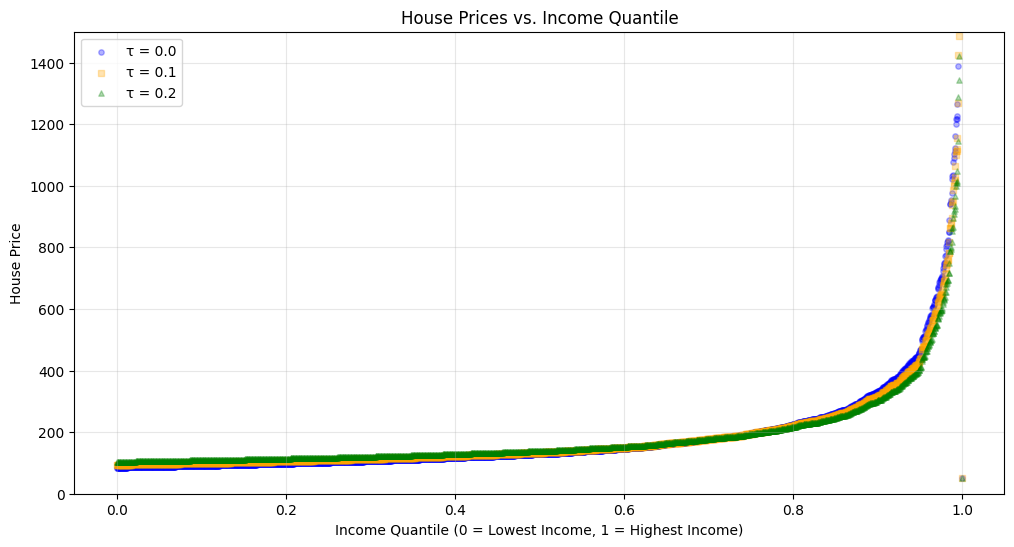

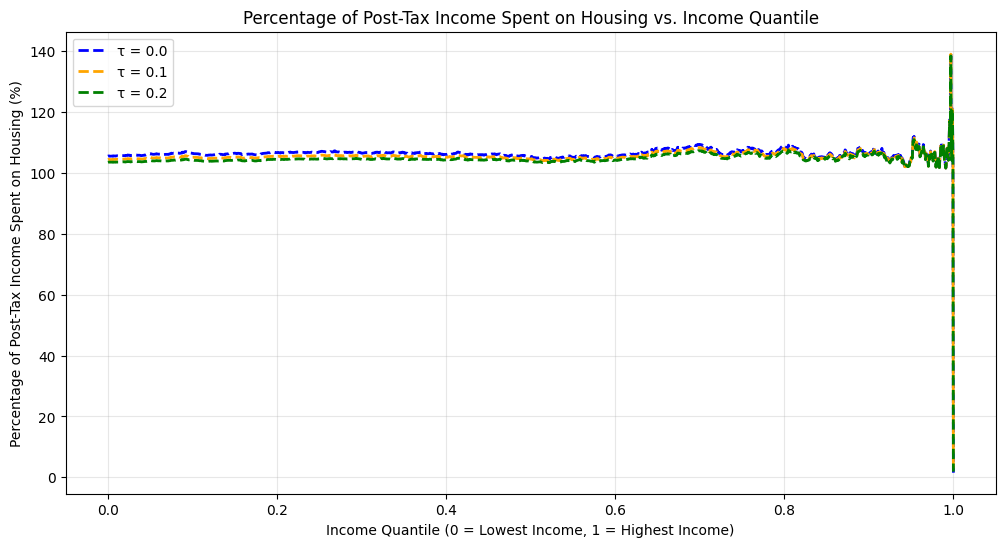

In [169]:
n=2000
y_min=80
alpha=1.75
mu=10
c=50
tau_list=[0.0,0.1,0.2]
seed=1

# Store data for all tax rates
all_y = []      # pre-tax incomes
all_x = []      # post-tax incomes
all_prices = []
for tau in tau_list:
    y, x, d = gen_data_with_tax(n, y_min, alpha, mu, c, tau, seed)
    prices = calc_prices_recursive(n, c, x, d)  # using post tax income (x) for calculations 
    all_y.append(y)
    all_x.append(x)
    all_prices.append(prices)

income_quantiles = np.linspace(0, 1, n)

# First Plot: House Prices vs Income Quantile
plt.figure(figsize=(12, 6))
colors = ['blue', 'orange', 'green']
markers = ['o', 's', '^']
for prices, tau, color, marker in zip(all_prices, tau_list, colors, markers):
    plt.scatter(income_quantiles, prices, 
               s=15,
               alpha=0.3,
               color=color,
               marker=marker,
               label=f'τ = {tau}')
plt.ylim(0, 1500)
plt.xlabel('Income Quantile (0 = Lowest Income, 1 = Highest Income)')
plt.ylabel('House Price')
plt.title('House Prices vs. Income Quantile')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

# Second Plot: Percentage of Income Spent (using post-tax income)
plt.figure(figsize=(12, 6))
for x, prices, tau, color in zip(all_x, all_prices, tau_list, colors):  # Using x 
    percentage_spent = np.where(x != 0, (prices / x) * 100, 0)  # using x
    plt.plot(income_quantiles, percentage_spent, 
            linestyle='--', 
            color=color,
            linewidth=2,
            label=f'τ = {tau}')
plt.xlabel('Income Quantile (0 = Lowest Income, 1 = Highest Income)')
plt.ylabel('Percentage of Post-Tax Income Spent on Housing (%)') 
plt.title('Percentage of Post-Tax Income Spent on Housing vs. Income Quantile')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

# All in one approach

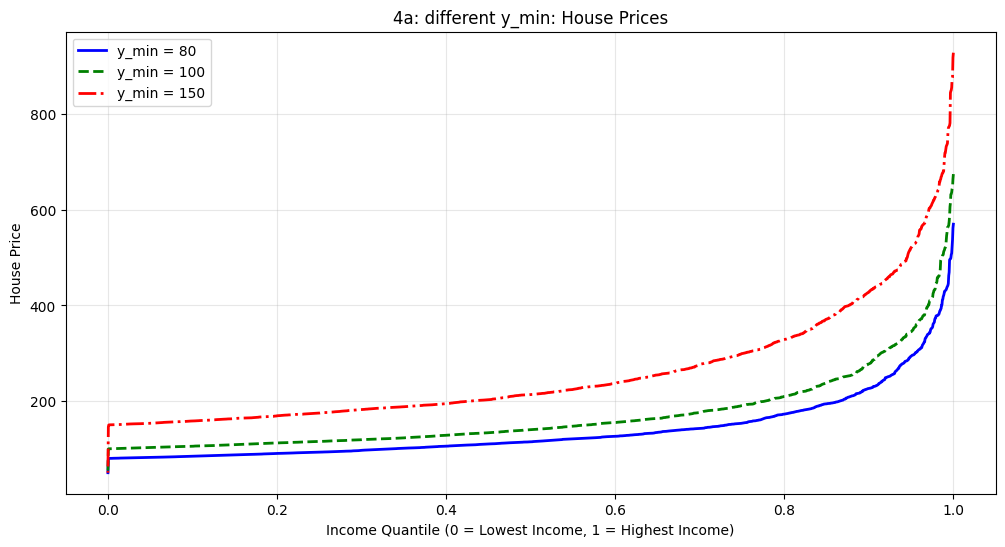

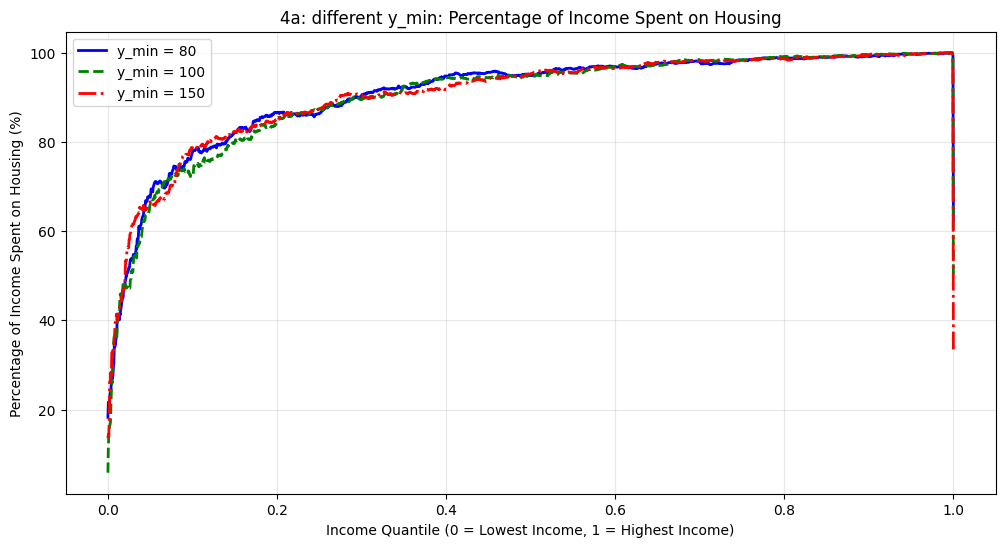

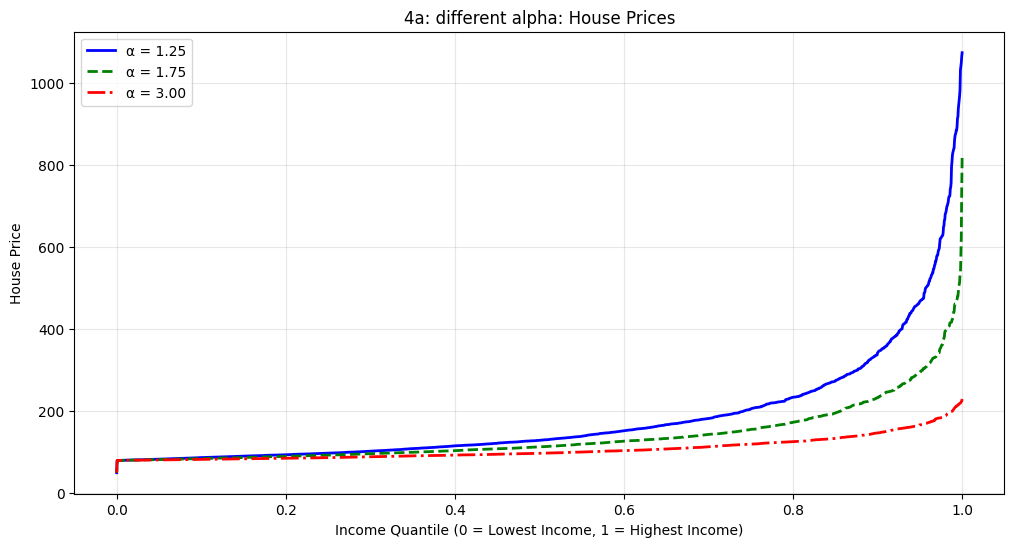

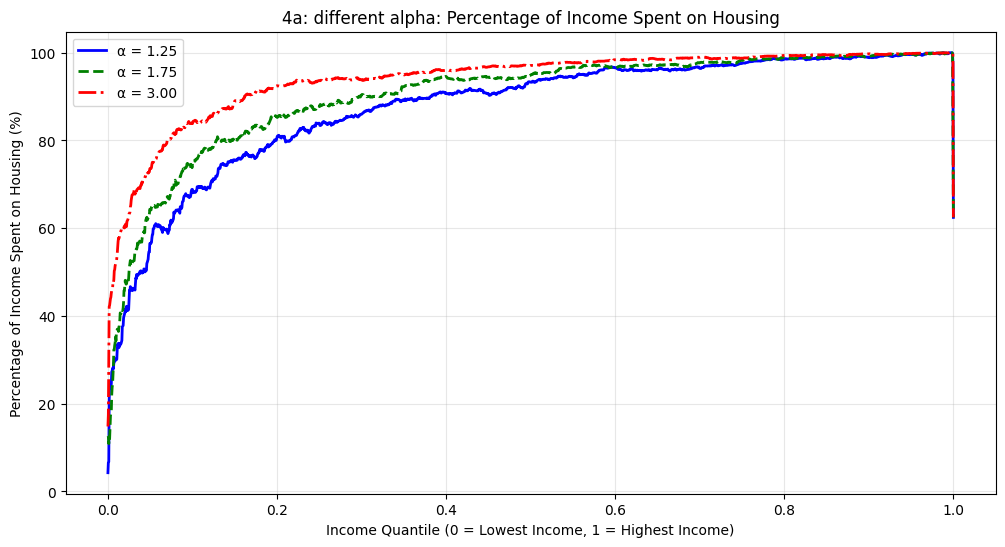

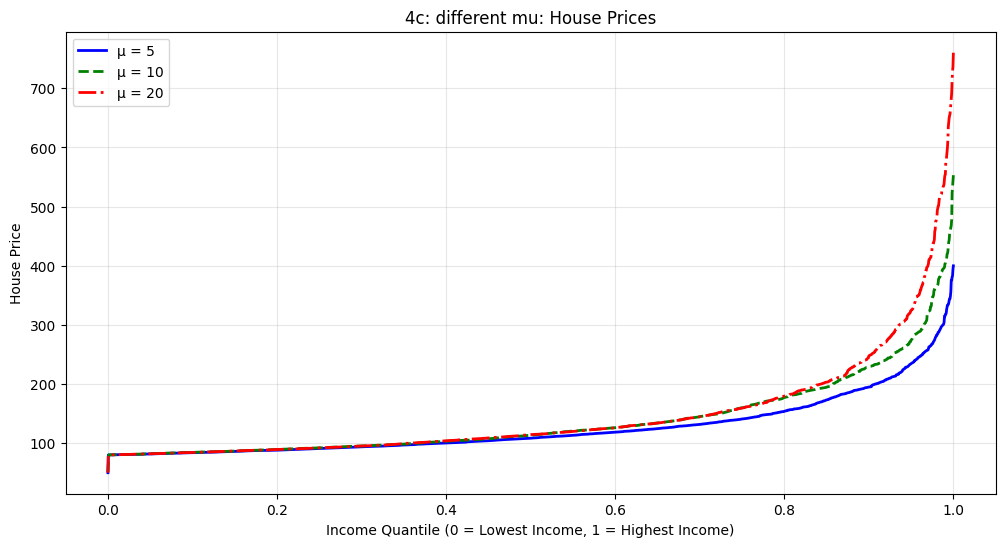

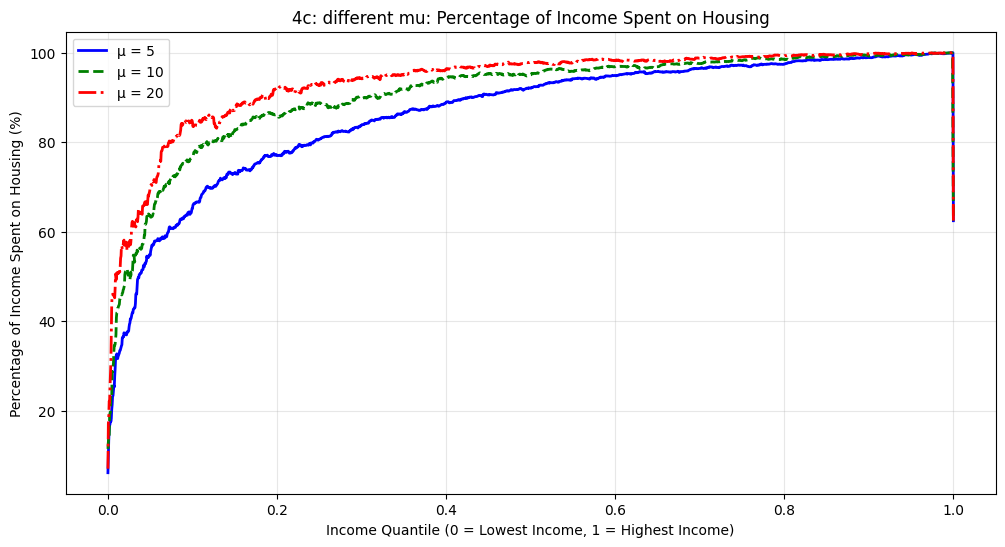

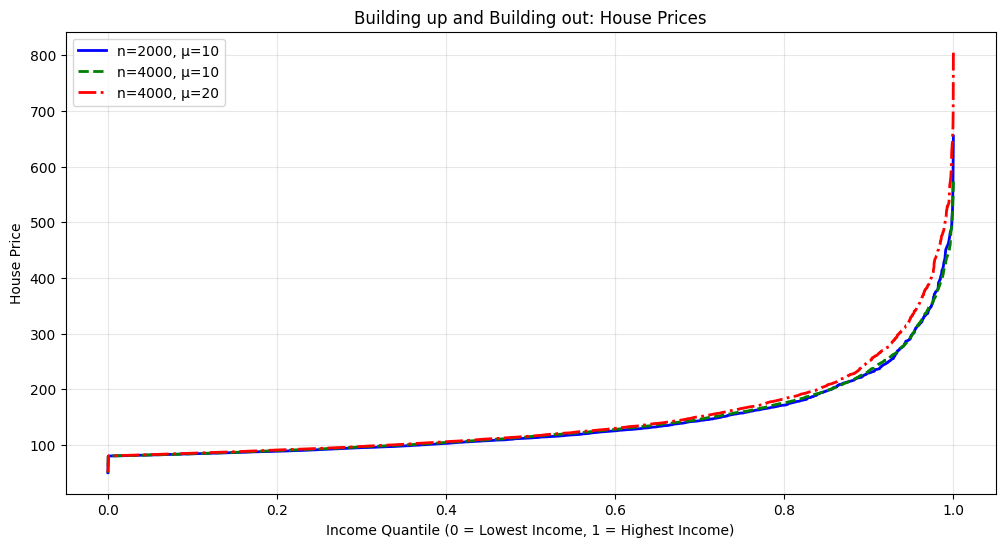

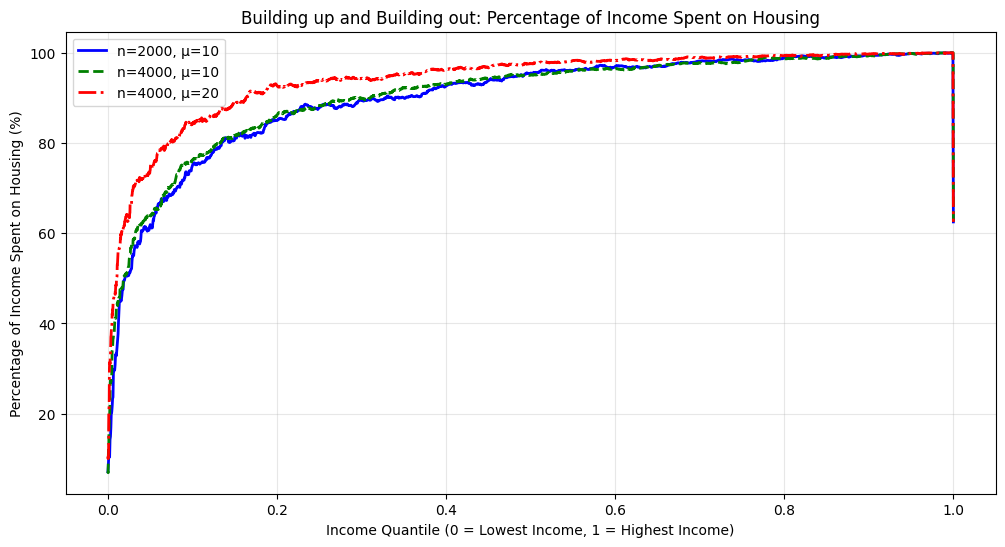

In [170]:
scenarios = [
    # 4a: Varying y_min
    {"y_min": 80, "n": 2000, "mu": 10, "c": 50, "alpha": 1.75, "label": "y_min = 80"},
    {"y_min": 100, "n": 2000, "mu": 10, "c": 50, "alpha": 1.75, "label": "y_min = 100"},
    {"y_min": 150, "n": 2000, "mu": 10, "c": 50, "alpha": 1.75, "label": "y_min = 150"},
    
    # 4b: Varying alpha
    {"alpha": 1.25, "y_min": 80, "n": 2000, "mu": 10, "c": 50, "label": "α = 1.25"},
    {"alpha": 1.75, "y_min": 80, "n": 2000, "mu": 10, "c": 50, "label": "α = 1.75"},
    {"alpha": 3.00, "y_min": 80, "n": 2000, "mu": 10, "c": 50, "label": "α = 3.00"},
    
    # 4c: Varying mu
    {"mu": 5, "y_min": 80, "n": 2000, "c": 50, "alpha": 1.75, "label": "μ = 5"},
    {"mu": 10, "y_min": 80, "n": 2000, "c": 50, "alpha": 1.75, "label": "μ = 10"},
    {"mu": 20, "y_min": 80, "n": 2000, "c": 50, "alpha": 1.75, "label": "μ = 20"},
   
    # Building up and out
    {"n": 2000, "mu": 10, "y_min": 80, "c": 50, "alpha": 1.75, "label": "n=2000, μ=10"},
    {"n": 4000, "mu": 10, "y_min": 80, "c": 50, "alpha": 1.75, "label": "n=4000, μ=10"},
    {"n": 4000, "mu": 20, "y_min": 80, "c": 50, "alpha": 1.75, "label": "n=4000, μ=20"}
]

def plot_scenario_group(scenario_group, title_base, zoom=False):
 
    # Store results
    all_prices = []
    all_quantiles = []
    all_y = []
    
    # Generate data for each scenario
    for scenario in scenario_group:
        # Generate data and calculate prices
        y, d = gen_data(scenario['n'], scenario['y_min'], scenario['alpha'], 
                       scenario['mu'], scenario['c'], seed)
        prices = calc_prices_iterative(scenario['n'], scenario['c'], y, d)
        
        # Store results
        all_prices.append(prices)
        all_quantiles.append(np.linspace(1, 0, len(prices)))
        all_y.append(y)
    
    # First plot: House Prices
    plt.figure(figsize=(12, 6))
    styles = ['-', '--', '-.']
    colors = ['blue', 'green', 'red']
    
    for (prices, quantiles, scenario, style, color) in zip(
            all_prices, all_quantiles, scenario_group, styles, colors):
        plt.plot(quantiles, prices, 
                linestyle=style,
                color=color,
                label=scenario['label'],
                linewidth=2)
    
    plt.xlabel('Income Quantile (0 = Lowest Income, 1 = Highest Income)')
    plt.ylabel('House Price')
    plt.title(f'{title_base}: House Prices')
    plt.grid(True, alpha=0.3)
    plt.legend()
    
    if zoom:
        plt.xlim(0.98, 1.01)
    
    plt.show()
    
    # Second plot: Percentage of Income Spent
    plt.figure(figsize=(12, 6))
    
    for (y, prices, scenario, style, color) in zip(
            all_y, all_prices, scenario_group, styles, colors):
        percentage_spent = np.where(y != 0, (prices / y) * 100, 0)
        plt.plot(np.linspace(0, 1, len(y)), percentage_spent,
                linestyle=style,
                color=color,
                label=scenario['label'],
                linewidth=2)
    
    plt.xlabel('Income Quantile (0 = Lowest Income, 1 = Highest Income)')
    plt.ylabel('Percentage of Income Spent on Housing (%)')
    plt.title(f'{title_base}: Percentage of Income Spent on Housing')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()

# Plot each group using slices of your scenarios list
plot_scenario_group(scenarios[0:3], 
                   '4a: different y_min')

plot_scenario_group(scenarios[3:6],
                   '4a: different alpha')

plot_scenario_group(scenarios[6:9],
                   '4c: different mu')

plot_scenario_group(scenarios[9:12],
                   'Building up and Building out')



# Low Income Housing

In [171]:


def gen_data_restricted(n, y_min, alpha, mu, c, seed=1):
   
    if y_min <= c:
        raise ValueError("y_min needs to be greater than c")
    if alpha <= 1:
        raise ValueError("alpha needs to be greater than 1")
    if mu <= 0:
        raise ValueError("mu needs to be positive")
    if n % 2 != 0:
        raise ValueError("n must be even")

    # Set random seed for reproducibility
    np.random.seed(seed)

    # Generate incomes using a Pareto-like distribution
    U = np.random.uniform(size=n)
    y = y_min * (1 - U) ** (-1.0 / alpha)

    # Generate house distances using an exponential distribution
    U_exp = np.random.uniform(size=n)
    d = -mu * np.log(U_exp)

    # Sort incomes in descending order and distances in ascending order
    y = np.sort(y)[::-1]
    d = np.sort(d)

    # Identify restricted houses: every third house (1-based indexing: 3, 6, 9, ...)
    # In 0-based indexing: indices 2, 5, 8, ...
    restricted_houses = np.zeros(n, dtype=bool)
    restricted_houses[2::3] = True  # Set every third house as restricted

    # Split agents into high-income and low-income groups
    # Since n is even, the median splits the agents exactly in half
    m = n // 2
    high_income_agents = np.zeros(n, dtype=bool)
    high_income_agents[:m] = True          # First half are high-income
    low_income_agents = ~high_income_agents  # Second half are low-income

    return y, d, restricted_houses, high_income_agents, low_income_agents

def allocate_houses(y, d, restricted_houses, high_income_agents, low_income_agents):
   
    n = len(y)
    m = n // 2

    # Identify restricted and unrestricted houses
    restricted = np.where(restricted_houses)[0]
    unrestricted = np.where(~restricted_houses)[0]

    # High-income agents: first m agents
    high_agents = np.arange(m)
    # Low-income agents: last m agents
    low_agents = np.arange(m, n)

    # Number of unrestricted houses must be >= m
    if len(unrestricted) < m:
        raise ValueError("Not enough unrestricted houses for high-income agents.")

    # Assign the closest m unrestricted houses to high-income agents
    # Unrestricted houses are sorted ascendingly
    # Assign to high agents sorted by y descendingly
    high_agents_sorted = high_agents[np.argsort(-y[high_agents])]
    allocated_unrestricted = unrestricted[:m]
    # Create mapping: agent -> house
    high_allocation = dict(zip(high_agents_sorted, allocated_unrestricted))

    # Assign restricted houses to low-income agents
    # Restricted houses are sorted ascendingly
    low_agents_sorted = low_agents[np.argsort(-y[low_agents])]
    allocated_restricted = restricted[:len(low_agents_sorted)]
    low_allocation = {}
    for agent, house in zip(low_agents_sorted, allocated_restricted):
        low_allocation[agent] = house

    # If more low-income agents than restricted houses, assign remaining to unrestricted houses
    if len(low_agents_sorted) > len(restricted):
        extra_low_agents = low_agents_sorted[len(restricted):]
        # Assign to the farthest unrestricted houses not allocated to high-income agents
        remaining_unrestricted = unrestricted[m:]
        # Sort remaining unrestricted houses in descending order (farthest first)
        remaining_unrestricted_sorted = np.sort(remaining_unrestricted)[::-1]
        if len(remaining_unrestricted_sorted) < len(extra_low_agents):
            raise ValueError("Not enough unrestricted houses for low-income agents.")
        allocated_extra_unrestricted = remaining_unrestricted_sorted[:len(extra_low_agents)]
        for agent, house in zip(extra_low_agents, allocated_extra_unrestricted):
            low_allocation[agent] = house

    # Combine allocations
    agent_house = np.full(n, -1, dtype=int)
    for agent, house in high_allocation.items():
        agent_house[agent] = house
    for agent, house in low_allocation.items():
        agent_house[agent] = house

    # Verify all agents have been allocated
    if -1 in agent_house:
        raise ValueError("Not all agents have been allocated a house.")

    return agent_house

def compute_prices(y, d, agent_house, c, restricted_houses):
    n = len(y)
    p = np.full(n, c)

    # Split into high-income and low-income submarkets
    m = n // 2
    high_agents = np.arange(m)
    low_agents = np.arange(m, n)

    # Find houses allocated to high and low agents
    high_houses = agent_house[high_agents]
    low_houses = agent_house[low_agents]

    # Sort high_houses ascendingly (closest first)
    high_houses_sorted = np.sort(high_houses)
    # Sort high_agents by descending y
    high_agents_sorted_by_y = high_agents[np.argsort(-y[high_agents])]

    # Sort low_houses ascendingly (closest first)
    low_houses_sorted = np.sort(low_houses)
    # Sort low_agents by descending y
    low_agents_sorted_by_y = low_agents[np.argsort(-y[low_agents])]

    # Compute prices for high-income submarket
    m_high = len(high_houses_sorted)
    if m_high > 0:
        p_high = np.zeros(m_high)
        # Initialize the farthest house price to c
        p_high[-1] = max(c, c)  # Ensures price is at least c
        # Iterate from the second farthest to the closest house
        for j in range(m_high - 2, -1, -1):
            delta_d = d[high_houses_sorted[j+1]] - d[high_houses_sorted[j]]
            theta = np.exp(-delta_d)
            # y_next is the income of the next lower-income high-agent
            y_next = y[high_agents_sorted_by_y[j+1]]
            p_high[j] = theta * p_high[j+1] + (1 - theta) * y_next
            p_high[j] = max(p_high[j], c)
        # Assign computed prices to the corresponding houses
        p[high_houses_sorted] = p_high

    # Compute prices for low-income submarket
    m_low = len(low_houses_sorted)
    if m_low > 0:
        p_low = np.zeros(m_low)
        # Initialize the farthest house price to c
        p_low[-1] = max(c, c)  # Ensures price is at least c
        # Iterate from the second farthest to the closest house
        for j in range(m_low - 2, -1, -1):
            delta_d = d[low_houses_sorted[j+1]] - d[low_houses_sorted[j]]
            theta = np.exp(-delta_d)
            # y_next is the income of the next lower-income low-agent
            y_next = y[low_agents_sorted_by_y[j+1]]
            p_low[j] = theta * p_low[j+1] + (1 - theta) * y_next
            p_low[j] = max(p_low[j], c)
        # Assign computed prices to the corresponding houses
        p[low_houses_sorted] = p_low

    return p

def create_dataframe(y, d, p, agent_house, restricted_houses):
    n = len(y)
    agent_ids = np.arange(1, n+1)
    assigned_houses = agent_house + 1  # Convert to 1-based indexing for readability
    low_income_house = restricted_houses[agent_house]

    agent_df = pd.DataFrame({
        'Agent_ID': agent_ids,
        'Income_y': y,
        'House_ID': assigned_houses,
        'House_Distance_d': d[agent_house],
        'House_Price_p': p[agent_house],
        'Low_Income_House': low_income_house
    })
    return agent_df

def save_to_excel(df, filename="agent_allocation.xlsx"):
    """
    Saves the DataFrame to an Excel file.

    Parameters:
    - df (pd.DataFrame): The DataFrame to save.
    - filename (str): The name of the Excel file.
    """
    try:
        df.to_excel(filename, index=False)
        print(f"DataFrame successfully saved to '{filename}'.")
    except Exception as e:
        print(f"An error occurred while saving to Excel: {e}")

    # Define parameters
    n=2000
    y_min=80
    alpha=1.75
    mu=10
    c=50    

    # Step 1: Generate Data
    y, d, restricted_houses, high_income_agents, low_income_agents = gen_data_restricted(n, y_min, alpha, mu, c, seed)

    # Step 2: Allocate Houses
    agent_house = allocate_houses(y, d, restricted_houses, high_income_agents, low_income_agents)

    # Step 3: Compute Equilibrium Prices
    p = compute_prices(y, d, agent_house, c, restricted_houses)

    # Step 4: Create DataFrame with Low-Income House Indicator
    df = create_dataframe(y, d, p, agent_house, restricted_houses)

    # Display the DataFrame
    print("Agent Allocation and Pricing DataFrame:")
    print(df)

    # Step 5: Save DataFrame to Excel
    save_to_excel(df, filename="agent_allocation.xlsx")


In [172]:

# Example parameters
n=2000
y_min=80
alpha=1.75
mu=10
c=50

# Generate data
#y, d, restricted_houses, high_income_agents, low_income_agents = gen_restricted_data(n, y_min, alpha, mu, c, seed)

# Display the results
print(y)

print(d)


print(restricted_houses)

print(high_income_agents)


print(low_income_agents)

[  80.00522903   80.01838409   80.03496434 ... 2700.22145471 3183.08092468
 3312.59495811]
[1.24220141e-03 1.40189361e-02 1.68466797e-02 ... 7.20762740e+01
 7.82810410e+01 9.24130808e+01]
[False False  True ...  True False False]
[ True  True  True ... False False False]
[False False False ...  True  True  True]



## Running DocTest tests

This last step gets the DocTest system to check test cases in the documentation comments.
In this course, you won't need to modify the stuff below, or even understand the details.

In [173]:
import doctest
result = doctest.testmod(verbose=False)
if result[0] == 0:
    print(("Congratulations! You have passed all "+str(result[1])+" tests"))
else:
    print("Rats!")

Congratulations! You have passed all 0 tests
